In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point
import json
from tqdm.auto import tqdm
pd.set_option('min_rows', 30)
import sys
sys.path.append('..')
from importlib import reload
# import src.utils as utils
# reload(utils)
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [22]:
%%time
df = pd.read_csv("input/BCs_issued_by_AUP_TLADCs_2021FEB.csv")
bcs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_Coordinate, df.Y_Coordinate))
# get bounds of data set (with a small buffer), useful for clipping other datasets
bcs = bcs.set_crs(epsg=4326)
bounds4326 = bcs.total_bounds
bcs = bcs.to_crs(epsg=3857)
bounds3587 =  bcs.total_bounds

CPU times: user 38.6 s, sys: 0 ns, total: 38.6 s
Wall time: 38.6 s


In [23]:
x_delta3587 = bounds3587[2] - bounds3587[0]
y_delta3587 = bounds3587[3] - bounds3587[1]
bounds_buffered3587 = [bounds3587[0] - y_delta3587 / 200, bounds3587[1] - x_delta3587 / 200, bounds3587[2] + y_delta3587 / 200, bounds3587[3] + x_delta3587 / 200]
bounds_buffered3587

[19387061.59286898, -4479941.806020565, 19541543.951537177, -4283968.670463785]

In [24]:
x_delta4326 = bounds4326[2] - bounds4326[0]
y_delta4326 = bounds4326[3] - bounds4326[1]
bounds_buffered4326 = [bounds4326[0] - y_delta4326 / 200, bounds4326[1] - x_delta4326 / 200, bounds4326[2] + y_delta4326 / 200, bounds4326[3] + x_delta4326 / 200]
bounds_buffered4326

[174.15865864485, -37.2937968355, 175.54295485515, -35.877583094500004]

/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


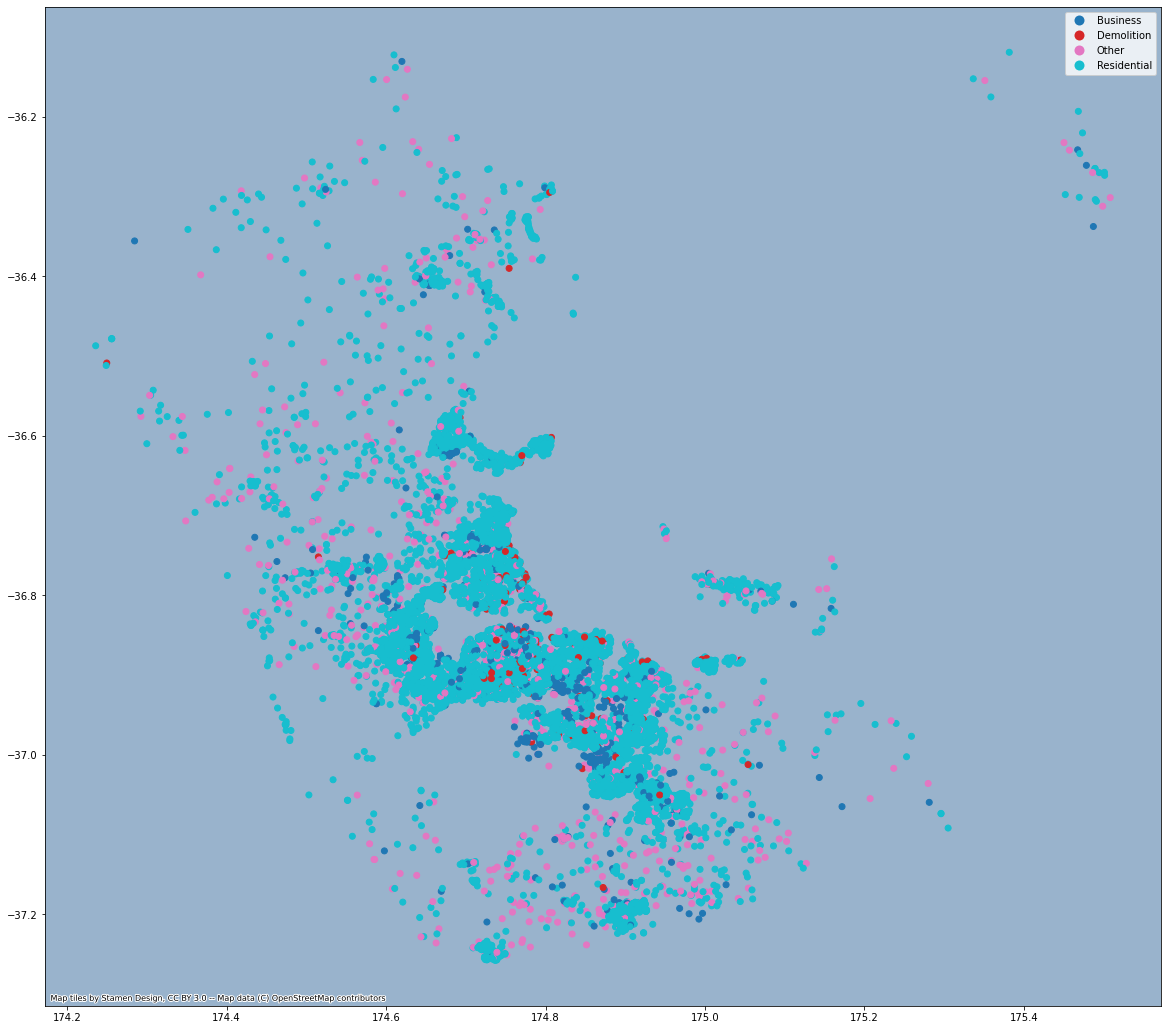

In [14]:
ax = bcs.sample(10000).plot(column='Building_Type_Group', legend=True, figsize=(20,20))
ctx.add_basemap(ax)

## Get more accurate coordinates from NZ addresses dataset

In [178]:
# addressing of building consents is very inconsistent
# some building consents have street name in ADDRESS_2, some have suburb, some even have 'Auckland'
bcs

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,number-name,number_name
0,227614,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",398 PAKIRI BLOCK ROAD,Tomarata,Auckland,Rodney,Houses,1111,231.0,NaN,1,Residential,Detached,NaN,NaN,2014,135900.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.634550,-36.224858,POINT (19440229.214 -4331605.710),398 pakiri,398 pakiri
1,227656,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Ahuroa Road,Puhoi,Auckland,Rodney,Non-building construction,3111,0.0,NaN,1,Other,NaN,NaN,NaN,2014,146701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.568721,-36.475863,POINT (19432901.152 -4366298.481),ahuroa road,ahuroa road
2,227796,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",Upper Orewa Road,Upper Orewa,Auckland,Rodney,"Townhouses, flats, units, and other dwellings",1129,260.0,NaN,2,Residential,Attached,NaN,NaN,2014,177701.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.641586,-36.590190,POINT (19441012.436 -4382137.395),upper orewa,upper orewa
3,227896,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",56 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,179.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (19429897.407 -4408234.527),56 vinistra,56 vinistra
4,227902,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",77 VINISTRA ROAD,Huapai,Auckland,Rodney,Houses,1111,180.0,NaN,1,Residential,Detached,NaN,NaN,2014,214900.0,2013.0,Road,General,27.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.541738,-36.778192,POINT (19429897.407 -4408234.527),77 vinistra,77 vinistra
5,227907,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",6 PITITI LANE,Huapai,Auckland,Rodney,Non-building construction,3111,0.0,NaN,1,Other,NaN,NaN,NaN,2014,215905.0,2013.0,Residential - Single House Zone,Residential,19.0,RDC_7,Future Urban,Rural,NaN,NaN,NaN,174.535847,-36.763621,POINT (19429241.602 -4406209.671),6 pititi,6 pititi
6,227911,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",753A COATESVILLE-RIVERHEAD HIGHWAY,Riverhead,Auckland,Rodney,Non-building construction,3111,0.0,NaN,1,Other,NaN,NaN,NaN,2014,214502.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.584367,-36.783907,POINT (19434642.824 -4409028.892),753a coatesville-riverhead,753a coatesville-riverhead
7,227912,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",21 DIAMOND LANE,Riverhead,Auckland,Rodney,Farm buildings,2711,313.0,NaN,1,Other,NaN,NaN,NaN,2014,216902.0,2013.0,Road,General,27.0,RDC_2,Countryside Living Rural,Rural,NaN,NaN,NaN,174.618681,-36.761155,POINT (19438462.685 -4405866.988),21 diamond,21 diamond
8,227925,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",447 OAIA ROAD,Muriwai Beach,Auckland,Rodney,Houses,1111,108.0,NaN,1,Residential,Detached,NaN,NaN,2014,219002.0,2013.0,Rural - Rural Coastal Zone,Rural,46.0,RDC_15,Landscape Protection Rur,Rural,NaN,NaN,NaN,174.433349,-36.837966,POINT (19417831.599 -4416545.305),447 oaia,447 oaia
9,227954,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",60 CLARK ROAD,Hobsonville,Auckland,Upper Harbour,Houses,1111,195.0,NaN,1,Residential,Detached,NaN,NaN,2014,222600.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_16,Special Area,Special,NaN,"Scott Point, Sunderland Precinct, Hobsonville ...","Scott Point, Sunderland Precinct, Hobsonville ...",174.652342,-36.798024,POINT (19442209.755 -4410991.217),60 clark,60 clark


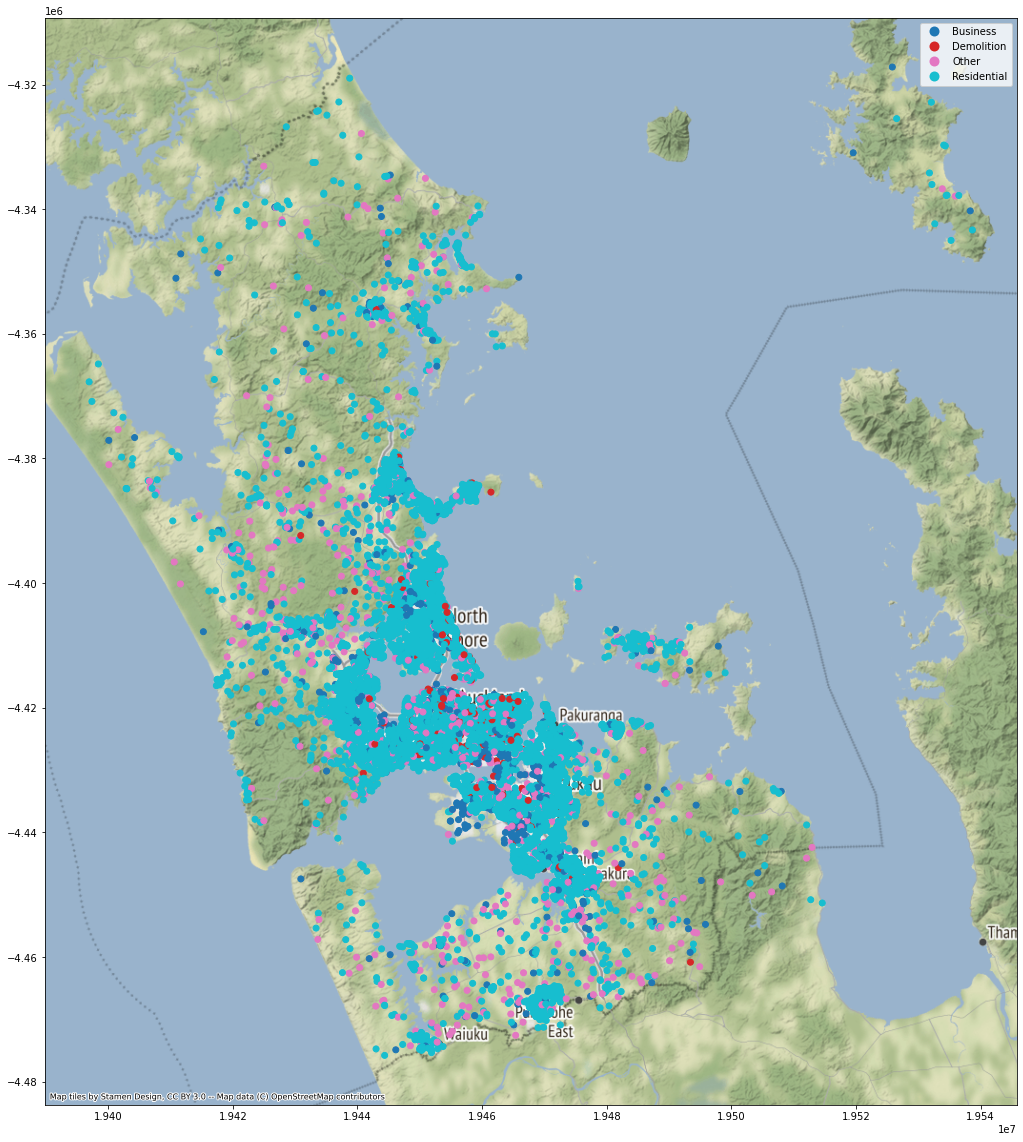

In [12]:
ax = bcs.sample(10000).plot(column='Building_Type_Group', legend=True, figsize=(20,20))
ctx.add_basemap(ax)

In [34]:
# read in address dataset
# https://data.linz.govt.nz/layer/53353-nz-street-address/
layer = gpd.read_file('input/lds-nz-street-address-GPKG.zip!nz-street-address.gpkg')
print(layer.crs)

/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [50]:
# restrict to within bounds of building consents data
addresses = layer.cx[bounds_buffered4326[0]:bounds_buffered4326[2], bounds_buffered4326[1]:bounds_buffered4326[3]]
addresses = addresses.to_crs(3587)

In [67]:
bcs.sample(20)

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry
17547,199832,"Jul 01, 2019 12:00:00 AM","Mar 01, 2020 12:00:00 AM",30A BERNARD MAGNUS LANE,Greenhithe,Auckland,Upper Harbour,Houses,1111,303.0,900000.0,1,Residential,Detached,NaN,NaN,2014,181303.0,2013.0,Residential - Large Lot Zone,Residential,23.0,NSC_625,Area B: Large Lot Reside,Special,NaN,NaN,NaN,174.690295,-36.772199,POINT (19446434.730 -4407401.659)
177411,91541,"Aug 01, 2003 12:00:00 AM","Apr 01, 2004 12:00:00 AM",8,KNIGHT RIDGE RD,SOUTH COVE,Rodney,"New (and pre-built) house, unit, bach, crib, b...",1100,102.0,85000.0,1,Residential,Detached,NaN,NaN,1998,142100.0,2013.0,Residential - Rural and Coastal Settlement Zone,Residential,20.0,RDC_14,Kawau Settlement Policy,Rural,NaN,NaN,NaN,174.841345,-36.442815,POINT (19463249.450 -4361724.357)
36806,173376,"Jul 01, 2017 12:00:00 AM","Mar 01, 2018 12:00:00 AM",26 JOMAC PLACE,Avondale,Auckland,Whau,Storage buildings,2611,2473.0,1000000.0,1,Business,NaN,Group 1,Factories/Warehouses,2014,389400.0,2013.0,Business - Light Industry Zone,Business,17.0,ACC_5,Business 5,Business,Industrial,NaN,NaN,174.683989,-36.881272,POINT (19445732.683 -4422570.524)
30753,179430,"Apr 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",902 GREAT SOUTH ROAD,Manukau Central,Auckland,Manurewa,"Townhouses, flats, units, and other dwellings",1129,85.0,141700.0,1,Residential,Attached,NaN,NaN,2014,780510.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,MCC_MR,Main Residential,Residential,NaN,NaN,NaN,174.891370,-37.007209,POINT (19468818.219 -4440111.643)
126609,3543,"Nov 01, 1991 12:00:00 AM","Apr 01, 1992 12:00:00 AM",8,MAPAU RD,GREENLANE,Albert - Eden,"New (and pre-built) house, unit, bach, crib, b...",1100,153.0,108000.0,1,Residential,Detached,NaN,NaN,1998,494000.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,ACC_24,Residential 6a,Residential,NaN,NaN,NaN,174.792091,-36.887874,POINT (19457766.587 -4423489.437)
165518,103623,"Feb 01, 2005 12:00:00 AM","Apr 01, 2005 12:00:00 AM",27,WHITBY CRES,MAIRANGI BAY,Hibiscus and Bays,"New (and pre-built) house, unit, bach, crib, b...",1100,435.0,750000.0,1,Residential,Detached,NaN,NaN,1998,149600.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,NSC_542,Residential 4B,Residential,NaN,NaN,NaN,174.757441,-36.741191,POINT (19453909.322 -4403093.329)
56180,153194,"Oct 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",229,HUIA RD,TITIRANGI,Waitakere Ranges,"New (and pre-built) house, unit, bach, crib, b...",1100,132.0,390000.0,1,Residential,Detached,NaN,NaN,1998,300503.0,2013.0,Residential - Large Lot Zone,Residential,23.0,WCC_23,TLSA 2,Rural,NaN,NaN,NaN,174.639000,-36.948365,POINT (19440724.519 -4431911.931)
54210,154741,"Feb 01, 2015 12:00:00 AM","Mar 01, 2015 12:00:00 AM",38,SEDGEBROOK RD,PUKEKOHE,Franklin,"New Other - eg implement shed, stable",1499,517.0,194200.0,1,Other,NaN,NaN,NaN,1998,811900.0,2013.0,Rural - Rural Production Zone,Rural,16.0,FDC_11,Rural,Rural,NaN,NaN,NaN,174.835341,-37.192732,POINT (19462581.099 -4466005.236)
188183,80931,"Jun 01, 2002 12:00:00 AM","Apr 01, 2003 12:00:00 AM",15,CHELMSLEY AVE,WESTERN HEIGHTS,Henderson - Massey,"New (and pre-built) house, unit, bach, crib, b...",1100,146.0,125600.0,1,Residential,Detached,NaN,NaN,1998,236810.0,2013.0,Residential - Single House Zone,Residential,19.0,WCC_7,Living,Residential,NaN,NaN,NaN,174.609804,-36.878590,POINT (19437474.480 -4422197.335)
201933,66915,"Jun 01, 2000 12:00:00 AM","Apr 01, 2001 12:00:00 AM",24,GRAMPIAN RD,KOHIMARAMA,Orakei,"New (and pre-built) house, unit, bach, crib, b...",1100,307.0,270000.0,1,Residential,Detached,NaN,NaN,1998,508100.0,2013.0,Residential - Mixed Ho

In [122]:
bcs[bcs.ADDRESS_2 == 'Auckland']

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry
14062,206569,"Nov 01, 2019 12:00:00 AM","Mar 01, 2020 12:00:00 AM",56 Brigham Street,Auckland,Auckland,Waitemata,Storage buildings,2611,3281.0,1500000.0,1,Business,NaN,Group 1,Factories/Warehouses,2014,432400.0,2013.0,Business - City Centre Zone,Business,35.0,CBD_49,Wynyard Quarter P,Business,Commercial,NaN,NaN,174.757106,-36.839094,POINT (19453872.064 -4416702.283)
24601,188214,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,Non-building construction,3111,0.0,40000.0,1,Other,NaN,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24603,188216,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,136.0,243439.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24604,188217,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,136.0,245889.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24605,188218,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,129.0,233100.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24606,188219,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,104.0,188640.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24607,188220,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,104.0,188640.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24608,188221,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,104.0,188640.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24609,188222,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townho

In [130]:
# get number and name of street (but not 'road', 'street', 'place' etc)
def number_name_bc(x):
    """extract street number and first complete word of the street name from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3]]).lower()
        return ' '.join(joined_address.split(' ')[:2])

bcs['number_name'] = bcs.apply(number_name_bc, axis=1)
# to have successfully extracted the name as the second 'word': the last character is never numeric
# there will still be some cases where there is no street number
print(sum(bcs['number_name'].apply(lambda x: x[-1] in [i for i in range(10)])))
bcs.number_name

0


0           398 pakiri
1          ahuroa road
2          upper orewa
3          56 vinistra
              ...     
207222     464 remuera
207223    55b panorama
207224      67 customs
207225      67 customs
Name: number_name, Length: 207226, dtype: object

In [202]:
def number_name_addresses(x):
    return ' '.join(x.full_address.split(' ')[:2]).lower()
addresses['number_name'] = addresses.apply(number_name_addresses, axis=1)

In [270]:
addresses

,address_id,change_id,address_type,unit_value,address_number,address_number_suffix,address_number_high,water_route_name,water_name,suburb_locality,town_city,full_address_number,full_road_name,full_address,road_section_id,gd2000_xcoord,gd2000_ycoord,water_route_name_ascii,water_name_ascii,suburb_locality_ascii,town_city_ascii,full_road_name_ascii,full_address_ascii,geometry,number_name
0,2045796,2863655,Road,None,26,A,NaN,None,None,Kaukapakapa,None,26A,Henley Road,"26A Henley Road, Kaukapakapa",379281,174.497848,-36.630429,None,None,Kaukapakapa,None,Henley Road,"26A Henley Road, Kaukapakapa",POINT (19425011.548 -4387717.848),26a henley
1,2045797,2863656,Road,None,26,B,NaN,None,None,Kaukapakapa,None,26B,Henley Road,"26B Henley Road, Kaukapakapa",379281,174.497236,-36.630864,None,None,Kaukapakapa,None,Henley Road,"26B Henley Road, Kaukapakapa",POINT (19424943.402 -4387778.133),26b henley
2,2046395,2863772,Road,None,34,B,NaN,None,None,Manly,Whangaparaoa,34B,Rawhiti Road,"34B Rawhiti Road, Manly, Whangaparaoa",346018,174.760415,-36.632911,None,None,Manly,Whangaparaoa,Rawhiti Road,"34B Rawhiti Road, Manly, Whangaparaoa",POINT (19454240.357 -4388062.146),34b rawhiti
4,2010077,1897733,Road,1,31,None,NaN,None,None,Birkenhead,Auckland,1/31,Rawene Road,"1/31 Rawene Road, Birkenhead, Auckland",175717,174.725070,-36.813514,None,None,Birkenhead,Auckland,Rawene Road,"1/31 Rawene Road, Birkenhead, Auckland",POINT (19450305.821 -4413144.867),1/31 rawene
5,2094408,2871149,Road,None,126,B,NaN,None,None,Shelly Park,Auckland,126B,Sandspit Road,"126B Sandspit Road, Shelly Park, Auckland",304746,174.944939,-36.909427,None,None,Shelly Park,Auckland,Sandspit Road,"126B Sandspit Road, Shelly Park, Auckland",POINT (19474781.515 -4426489.651),126b sandspit
6,2094409,2871150,Road,None,126,C,NaN,None,None,Shelly Park,Auckland,126C,Sandspit Road,"126C Sandspit Road, Shelly Park, Auckland",304746,174.945163,-36.909584,None,None,Shelly Park,Auckland,Sandspit Road,"126C Sandspit Road, Shelly Park, Auckland",POINT (19474806.435 -4426511.440),126c sandspit
7,2094410,2871151,Road,None,126,D,NaN,None,None,Shelly Park,Auckland,126D,Sandspit Road,"126D Sandspit Road, Shelly Park, Auckland",304746,174.945393,-36.909477,None,None,Shelly Park,Auckland,Sandspit Road,"126D Sandspit Road, Shelly Park, Auckland",POINT (19474832.016 -4426496.546),126d sandspit
8,2099790,2863073,Road,1,19,None,NaN,None,None,Mount Wellington,Auckland,"Flat 1, 19",Dinglebank Road,"Flat 1, 19 Dinglebank Road, Mount Wellington, ...",335804,174.827497,-36.896530,None,None,Mount Wellington,Auckland,Dinglebank Road,"Flat 1, 19 Dinglebank Road, Mount Wellington, ...",POINT (19461707.894 -4424694.193),"flat 1,"
9,2099791,2863074,Road,2,19,None,NaN,None,None,Mount Wellington,Auckland,"Flat 2, 19",Dinglebank Road,"Flat 2, 19 Dinglebank Road, Mount Wellington, ...",335804,174.827416,-36.896473,None,None,Mount Wellington,Auckland,Dinglebank Road,"Flat 2, 19 Dinglebank Road, Mount Wellington, ...",POINT (19461698.974 -4424686.292),"flat 2,"
10,2099792,2863075,Road,3,18,None,NaN,None,None,Mount Wellington,Auckland,"Flat 3, 18",Dinglebank Road,"Flat 3, 18 Dinglebank Road, Mount Wellington, ...",335804,174.827448,-36.896379,None,None,Mount Wellington,Auckland,Dinglebank Road,"Flat 3, 18 Dinglebank Road, Mount Wellington, ...",POINT (19461702.443 -4424673.123),"flat 3,"


In [ ]:
nB = np.array(list(addresses.geometry.apply(lambda x: (x.x, x.y))))

In [269]:
# function for applying to rows:
# first find closest k addresses, then check if there is a match between number + first word of address
gdB = addresses
btree = cKDTree(nB)
def find_address_match(x, k=1000):
    # check the nearest k points for a match between 
    # the point taken from the building consent in question
    nA = np.array(list(x.geometry.apply(lambda x: (x.x, x.y))))
#     print(nA)
    # distance and idx of nearest point(s)
    dist, idx = btree.query(nA, k=k)
#     print(idx)
    if isinstance(idx, int):
        idx = [idx]

    gdB_nearest = gdB.iloc[idx[0]]
    gdb_match = gdB_nearest[gdB_nearest.number_name == x.number_name.values[0]]
    if len(gdb_match) == 1:
        # one match
        return 'match'
    elif len(gdb_match) == 0:
        # zero matches
        return 'no_match'
    else:
        # more than one match (probably not safe to take the closest)
        return 'ambiguous'

In [313]:
# test on a small sample, for different values of k
# filter to those with a valid ADDRESS_1
bcs_filtered = bcs[~bcs.ADDRESS_1.isna()]
# filter to those with a street/road number
bcs_filtered = bcs_with_address1[bcs_with_address1.ADDRESS_1.str.slice(0, 1).isin([str(i) for i in range(10)])]
sample_idx = np.random.randint(0, len(bcs_with_address1), 500)
results = {}
for k in [200, 1000, 5000]:
    results[k] = []
    for i in tqdm(sample_idx):
        x = bcs_with_address1.iloc[[i]]
        results[k].append(find_address_match(x, k=k))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [319]:
for k, result in results.items():
    print('-------', k, '-------')
    for s in ['match', 'no_match', 'ambiguous']:
        print(s, sum([r == s for r in result]) / len(result))

------- 200 -------
match 0.806
no_match 0.194
ambiguous 0.0
------- 1000 -------
match 0.81
no_match 0.188
ambiguous 0.002
------- 5000 -------
match 0.814
no_match 0.18
ambiguous 0.006


In [299]:
# number of building consents that don't have NA for ADDRESS_1, and also don't have an address starting with a number
len([a for a in bcs[~bcs.ADDRESS_1.isna()].ADDRESS_1 if not a[0] in [str(i) for i in range(10)]])

3725

## Join BCs with NZ Parcels

In [ ]:
%%time
nz_parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb')
print(nz_parcels.crs)
nz_parcels = nz_parcels.to_crs(3587)
nz_parcels = nz_parcels.cx[bounds_buffered3857[0]:bounds_buffered3857[2], bounds_buffered3857[1]:bounds_buffered3857[3]]